# MIGHT Power with Permutation, Coleman-permute-once, and Coleman-permute-per-tree

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier, build_coleman_forest
from sktree.tree import DecisionTreeClassifier

In [3]:
SIMULATIONS = {
    "1": {},
    "3": {"band_type": "ar", "rho": 0.5},
    "4": {"band_type": "ar", "m_factor": 1, "rho": 0.5},
}

In [4]:
n_estimators = 500
seed = 1234
n_jobs = -1

n_jobs_trees = 1

In [5]:
COLEMAN_MODELS = {
    "permute_once": {
        "n_estimators": n_estimators,
        "random_state": None,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs_trees,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
        "permute_per_tree": False,
    },
    "permute_per_tree": {
        "n_estimators": n_estimators,
        "random_state": None,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs_trees,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
        "permute_per_tree": True,
    },
}

model_names = [
    # "permutation-test",
    "permute_once",
    # "permute_per_tree"
]

In [6]:
SAMP_SIZES = [2**i for i in range(8, 12)]
SAMP_SIZES_plot = [2 * 2**i for i in range(8, 10)]
DIM = 4**6
REPS = range(100, 1000)
P = 4096
# SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/power_exp/might-honestfraction05-bootstrap-maxsamples16-permutepertree"
SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/m_factor=-1/"
# SAVE_PATH = "/Users/adam2392/Documents/might/test/output/"
print(SAMP_SIZES)
n_repeats = 500

SIM_TYPES = [
    # "trunk",
    # "trunk-overlap",
    "trunk-05"
]

[256, 512, 1024, 2048]


In [8]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 14))
results = defaultdict(list)
permutation_test_results = defaultdict(list)
n_dims = 4096

# load pvalue versions of permutation test using ChenChen approach
# so each of these are a null and observed statistic
# model_name = "permutation-test_500"
for model_name in [
    "permutation-test_500",
    # "permutation-test"
]:
    for sim_name in SIM_TYPES:
        for n_samples in SAMP_SIZES:
            for idx in range(n_repeats):
                if sim_name == "trunk-05":
                    sim_type = sim_name[:-3]
                else:
                    sim_type = sim_name

                file_name = (
                    Path(SAVE_PATH)
                    / model_name
                    / sim_name
                    / f"might_{sim_type}_{n_samples}_{n_dims}_{idx}.npz"
                )
                if not file_name.exists():
                    print(f"Didn't find {file_name}")
                    continue

                data = np.load(file_name)

                # null stat
                might_permute_stat = data["might_permute_stat"]

                # observed stat
                might_stat = data["might_stat"]

                permutation_test_results["observe_stat"].append(float(might_stat))
                permutation_test_results["null_stat"].append(float(might_permute_stat))
                permutation_test_results["n_samples"].append(n_samples)
                # results['n_dims'].append(n_dims)
                permutation_test_results["sim_name"].append(sim_name)
                permutation_test_results["model"].append(model_name)
                permutation_test_results["idx"].append(idx)


# load pvalue versions with Coleman
for model_name in [
    # "permute_once",
    # "permute_per_tree",
    # "permute_per_tree_2x",
    # "permute_once_2x",
    # "permute_per_tree_4x",
    # "permute_once_4x",
    "permute_per_tree_4x10kreps",
    "permute_once_4x10kreps",
    # "permute_per_tree_100k50kreps",
    # "permute_once_100k50kreps",
    # "permute_per_tree_100k",
    # "permute_once_100k",
]:
    for sim_name in SIM_TYPES:
        for n_samples in SAMP_SIZES:
            for idx in range(100):
                if sim_name == "trunk-05":
                    sim_type = sim_name[:-3]
                else:
                    sim_type = sim_name

                file_name = (
                    Path(SAVE_PATH)
                    / model_name
                    / sim_name
                    / f"might_{sim_type}_{n_samples}_{n_dims}_{idx}.npz"
                )

                if not file_name.exists():
                    print(f"Didn't find {file_name}")
                    continue

                data = np.load(file_name)
                # print(dict(data).keys())
                pval = data["might_pvalue"]

                results["pvalue"].append(pval)
                results["n_samples"].append(n_samples)
                # results['n_dims'].append(n_dims)
                results["sim_name"].append(sim_name)
                results["model"].append(model_name)
                results["idx"].append(idx)

Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_50.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_51.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_52.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_53.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_54.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_55.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_56.npz
Didn't find /Volumes/Extreme Pro/cancer/output/m_factor=-1/permute_per_tree_4x10kreps/trunk-05/might_trunk_256_4096_57.npz
Didn't find /Vol

# Reformat into DataFrame to Plot

In [9]:
df = pd.DataFrame(results)

perm_df = pd.DataFrame(permutation_test_results)
print(df.shape)
print(perm_df.shape)

(400, 5)
(2000, 6)


In [10]:
display(df.head())

,pvalue,n_samples,sim_name,model,idx
0,0.20877912208779123,256,trunk-05,permute_per_tree_4x10kreps,0
1,0.7993200679932007,256,trunk-05,permute_per_tree_4x10kreps,1
2,0.42395760423957607,256,trunk-05,permute_per_tree_4x10kreps,2
3,0.9279072092790721,256,trunk-05,permute_per_tree_4x10kreps,3
4,0.195980401959804,256,trunk-05,permute_per_tree_4x10kreps,4


In [11]:
ALPHA = 0.05

perm_df["power"] = np.nan
for n_samples in SAMP_SIZES:
    for sim_name in SIM_TYPES:
        temp_df = perm_df[
            (perm_df["n_samples"] == n_samples) & (perm_df["sim_name"] == sim_name)
        ]
        n_reps = len(temp_df)
        null_dist = temp_df["null_stat"].to_numpy()
        alt_dist = temp_df["observe_stat"].to_numpy()

        # convert to empirical power per sample size
        cutoff = np.sort(null_dist)[math.ceil(n_reps * (1 - ALPHA)) - 1]
        empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + n_reps)
        perm_df.loc[
            (perm_df["n_samples"] == n_samples) & (perm_df["sim_name"] == sim_name),
            "power",
        ] = empirical_power

In [12]:
sim_to_viz = "trunk-overlap"
sim_to_viz = "trunk-05"
df = df[df["sim_name"] == sim_to_viz]

empirical_power = (1 + (df["pvalue"] <= 0.05).sum()) / (1 + len(df["pvalue"]))
print(empirical_power)

df["pvalue"] = df["pvalue"] < 0.05
df = df.groupby(["n_samples", "model"])["pvalue"].agg(["mean", "std"])
df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})

# display(df.head())

0.26932668329177056


In [13]:
perm_df = perm_df[perm_df["sim_name"] == sim_to_viz]

In [14]:
print(df.shape, perm_df.shape)

(8, 2) (2000, 7)


In [15]:
display(perm_df.groupby("model").aggregate("mean"))

/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_45937/1128504175.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(perm_df.groupby("model").aggregate("mean"))


,observe_stat,null_stat,n_samples,idx,power
model,,,,,
permutation-test_500,0.02325,0.017844,960.0,249.5,0.23004


# Plot

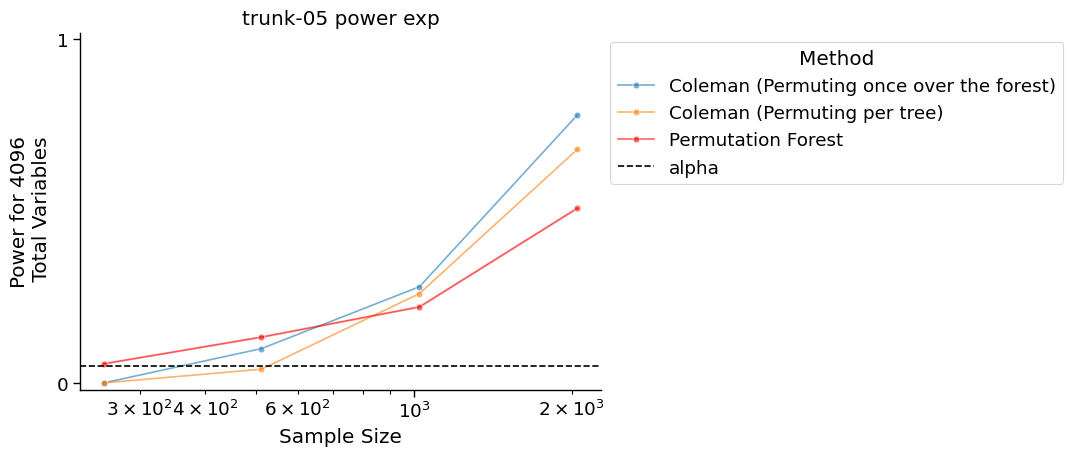

In [36]:
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots()

palette = {"permutation-test_500": "red", "permutation-test": "black"}

ax = sns.lineplot(
    data=df,
    # x="n_features_2",
    x="n_samples",
    y="pvalue",
    marker="o",
    hue="model",
    ax=ax,
    # palette=palette,
    errorbar="ci",
    alpha=0.6,
)

ax = sns.lineplot(
    data=perm_df,
    # x="n_features_2",
    x="n_samples",
    y="power",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
    alpha=0.6,
)

ax.set_ylabel("Power for 4096\n Total Variables")
ax.set_xlabel("Sample Size")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
    # title=f"Trunk with 0.5 separation",
    title=f"{sim_to_viz} power exp",
)
sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls="--", label="alpha")
ax.set_xscale("log")
# ax.set_ylabel(None)
# ax.legend()
# Rename legend labels
new_labels = {
    "permutation-test_500": "Permutation Forest",
    "permute_per_tree_4x10kreps": "Coleman (Permuting per tree)",
    "permute_once_4x10kreps": "Coleman (Permuting once over the forest)",
}  # Specify the mapping you want
leg = ax.legend(title="Method")

fig.tight_layout()
for t in leg.texts:
    if t.get_text() == "alpha":
        continue
    t.set_text(new_labels[t.get_text()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [107]:
print(power_MIGHT)

NameError: name 'power_MIGHT' is not defined

In [53]:
data = np.load("/Users/adam2392/Downloads/n_trees_exp.npz", allow_pickle=True)
results = data["results"]

In [58]:
print(results["sas98"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [24]:
A = np.array(
    [
        [1 / 2, -1 / 2, 0],
        [-1 / 2, 1, -1 / 2],
        [-1 / 2, 0, 1],
    ]
)

b = np.array([1, 1, 1])

print(np.linalg.solve(A, b))

[14. 12.  8.]
